In [1]:
import sys
sys.path.append('../utils')
sys.path.append('../')
import numpy as np
import scipy
import tqdm
import utils
import geometry
import ct_tools
import open3d as o3d
from open3d import io, visualization

import matplotlib.pyplot as plt
import plotly.graph_objects as go
import glob
import pydicom
import functools
import mcubes


In [2]:
#image = ct_tools.read_dicom('../series-00000/', HU = True, crop = 450, axis = 0)
image, voxel_size = ct_tools.read_dicom('../manifest-1600709154662/LIDC-IDRI/LIDC-IDRI-0002/01-01-2000-NA-NA-98329/3000522.000000-NA-04919', HU = True, crop = 415, axis = 0)



  0%|          | 0/261 [00:00<?, ?it/s]

100%|██████████| 261/261 [00:00<00:00, 448.65it/s]


In [3]:
print(voxel_size)

[0.00068164 0.00068164 0.00125   ]


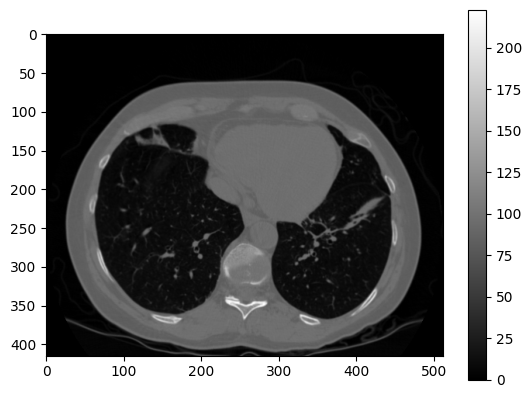

In [4]:
plt.imshow(image[:, :, 190])

plt.colorbar()
plt.gray()

In [5]:
opened = ct_tools.open(image, 5)


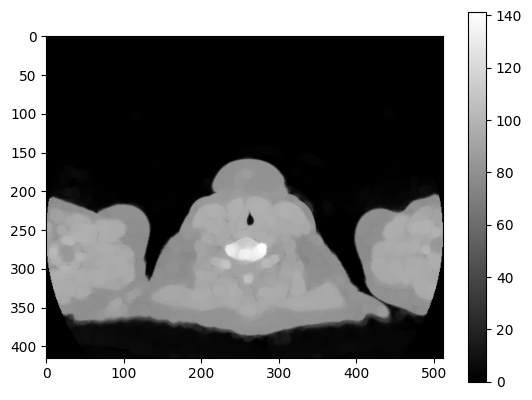

In [6]:
plt.imshow(opened[:, :, 0])
plt.colorbar()
plt.gray()

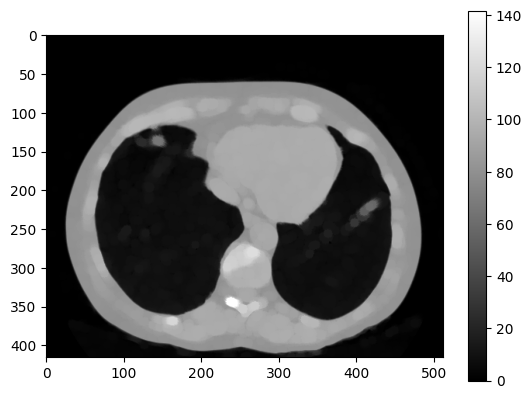

In [7]:
plt.imshow(opened[:, :, 190])
plt.colorbar()
plt.gray()

In [8]:
fg_mask = ct_tools.make_fg_mask(opened, opened.shape[2], fg_threshold = 60)



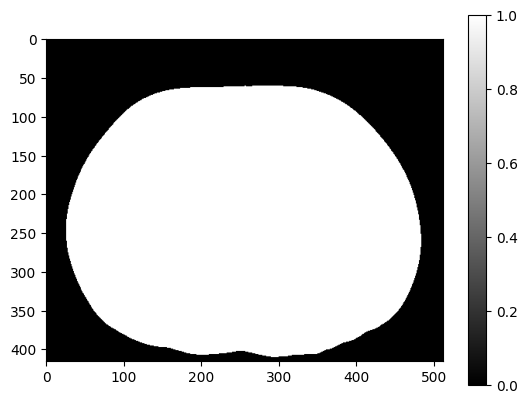

In [9]:
plt.imshow(fg_mask[:, :, 190])
plt.colorbar()
plt.gray()

In [10]:
vertices, triangles = ct_tools.make_surface_mesh(fg_mask, voxel_size, './thoracic_surface_smoothed_2.obj')


In [3]:
surface_mesh = io.read_triangle_mesh("thoracic_surface_smoothed.obj")

surface_mesh = o3d.t.geometry.TriangleMesh.from_legacy(surface_mesh)
surface_mesh.compute_vertex_normals()
surface_mesh.compute_triangle_normals()

vertices = surface_mesh.vertex.positions
vertex_normals = surface_mesh.vertex.normals
triangle_normals = surface_mesh.triangle.normals

# transducers = [transducer.Planewave(max_frequency=1e6,
#                                     elements = 32, 
#                                     width = 20e-3,
#                                     height =  20e-3,
#                                     sensor_sampling_scheme = 'not_centroid', 
#                                     sweep = np.pi/3,
#                                     ray_num = 32, 
#                                     imaging_ndims = 2,
#                                     focus_elevation = 20e-3,
#                                     ) for i in range(1)]

# for t in transducers:
#     t.make_sensor_coords(test_phantom.baseline[0])

# test_set = transducer_set.TransducerSet(transducers, seed=8888)
# test_transducer_set.assign_pose(0, geometry.Transform(-theta*normals[vertex_num], vertices[vertex_num]))

In [4]:
target_pt = np.array([150*voxel_size[0], 350*voxel_size[1], 190*voxel_size[2]])
print(target_pt)

chi = 0.25
alpha = 0.5*1**1.5 / 8.686 * 100
radius = -np.log(chi)/(2*alpha) # in meters to match mesh coordinate system

print(radius)

[0.10224615 0.23857435 0.2375    ]
0.1204135282068737


In [5]:
# begin snap-to-surface algo here

def snap_to_surface(point, surface):
    scene = o3d.t.geometry.RaycastingScene()
    _ = scene.add_triangles(surface)
    query_pt = o3d.core.Tensor([point], dtype=o3d.core.Dtype.Float32)
    closest_pt = scene.compute_closest_points(query_pt)
    closest_triangle = closest_pt['primitive_ids'][0].item()
    return closest_pt['points'].numpy(), closest_triangle

    return scene.compute_closest_points(query_pt), surface

closest_pt, closest_triangle = snap_to_surface([100*voxel_size[0], 400*voxel_size[1], 190*voxel_size[2]], surface_mesh)
print(closest_pt)





[[0.06576516 0.27472275 0.23697834]]


In [6]:
# begin inverse field of view code here 

#use boolean_intersection from o3d.t.geometry.TriangleMesh

sphere = o3d.t.geometry.TriangleMesh.from_legacy(o3d.geometry.TriangleMesh.create_sphere(radius).translate(target_pt))
# int_scene = o3d.t.geometry.RacastingScene()
# ids = {}
# ids[int_scene.add_triangles(surface_mesh)] = 'body_surface'
# ids[int_scene.add_triangles(sphere)] = 'sphere'

# intersection = surface_mesh.boolean_intersection(sphere)

# visualization.draw([{'name': 'intersection', 'geometry': intersection}])

In [ ]:
intersection = surface_mesh.boolean_intersection(sphere)


